## 객체인식

In [2]:
dir_data = 'dataset1/'
dir_seg = dir_data + '/annotations_prepped_train/'
dir_img = dir_data + '/images_prepped_train/'

In [3]:
import glob, os
all_img_paths = glob.glob(os.path.join(dir_img, '*.png'))
all_img_paths[-5:]

['dataset1//images_prepped_train\\0016E5_08520.png',
 'dataset1//images_prepped_train\\0016E5_08550.png',
 'dataset1//images_prepped_train\\0016E5_08580.png',
 'dataset1//images_prepped_train\\0016E5_08610.png',
 'dataset1//images_prepped_train\\0016E5_08640.png']

In [4]:
all_mask_paths = glob.glob(os.path.join(dir_seg, '*.png'))
all_mask_paths[:5]

['dataset1//annotations_prepped_train\\0001TP_006690.png',
 'dataset1//annotations_prepped_train\\0001TP_006720.png',
 'dataset1//annotations_prepped_train\\0001TP_006750.png',
 'dataset1//annotations_prepped_train\\0001TP_006780.png',
 'dataset1//annotations_prepped_train\\0001TP_006810.png']

In [5]:
all_img_paths[0].split('\\')[-1]

'0001TP_006690.png'

In [6]:
x = []
y = []
count = 0

In [9]:
!conda list opencv

# packages in environment at C:\ProgramData\Anaconda3\envs\cvtf2:
#
# Name                    Version                   Build  Channel


In [ ]:
!conda install -y opencv

In [12]:
import cv2
for i in range(len(all_img_paths)):
    img = cv2.imread(all_img_paths[i])
    img = cv2.resize(img, (224, 224))
    mask_path = dir_seg+all_img_paths[i].split('\\')[-1]
    img_mask = cv2.imread(mask_path)
    img_mask = cv2.resize(img_mask, (224, 224))
    x.append(img)
    y.append(img_mask)
    if(i%100==0):
        print(i)

0
100
200
300


In [13]:
import numpy as np
np.array(y).shape

(367, 224, 224, 3)

In [14]:
np.array(x).shape

(367, 224, 224, 3)

(array([82797.,  2079., 19554., 11745.,  2472.,  5469.,   393., 14874.,
         2094.,  9051.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

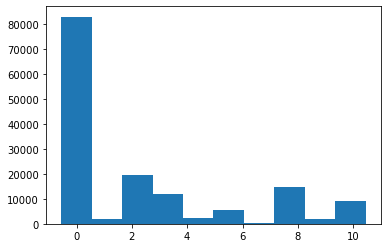

In [15]:
import matplotlib.pyplot as plt
x = np.array(x)
y = np.array(y)
plt.hist(y[2].flatten(), align='left')

In [16]:
y1 = np.where(y==8, 1., 0.)
y1.shape

(367, 224, 224, 3)

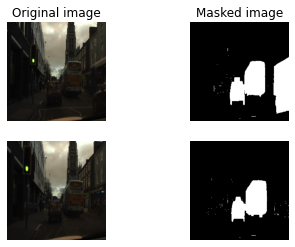

In [17]:
plt.subplot(221)
plt.imshow(x[1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')

plt.subplot(222)
plt.imshow(y1[1])
plt.axis('off')
plt.title('Masked image')
plt.grid('off')

plt.subplot(223)
plt.imshow(x[2])
plt.axis('off')
plt.grid('off')

plt.subplot(224)
plt.imshow(y1[2])
plt.axis('off')
plt.grid('off')

(array([1.0824e+04, 1.3260e+03, 6.3000e+01, 5.8500e+03, 3.0000e+00,
        1.8000e+01, 1.8000e+01, 1.8000e+01, 1.2000e+01, 4.6800e+02]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

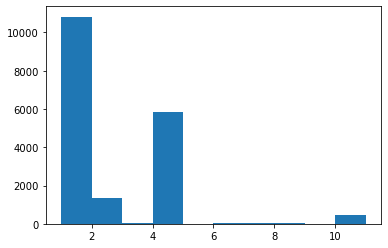

In [21]:
plt.hist(y[2, 100:, :50].flatten())

In [22]:
x = np.array(x)
y2 = np.array((y1)[:,:,:,0])
y2 = y2.reshape(y2.shape[0], y2.shape[1], y2.shape[2], 1)
print(x.shape, y2.shape)

(367, 224, 224, 3) (367, 224, 224, 1)


In [23]:
np.max(x)

255

In [24]:
x = x/255
print(np.max(x))

1.0


In [27]:
from tensorflow.keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_vgg16.trainable = False
base_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [34]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [35]:
conv1 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block4_conv3').output).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block5_conv3').output).output
drop5 = Dropout(0.5)(conv5)

In [37]:
up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
merge6 = concatenate([drop4, up6], axis=-1)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

In [38]:
up7 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
merge7 = concatenate([conv3, up7], axis=-1)
conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

In [39]:
up8 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
merge8 = concatenate([conv2, up8], axis=-1)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

In [40]:
up9 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
merge9 = concatenate([conv1, up9], axis=-1)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

In [41]:
conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

In [42]:
model = Model(inputs=base_vgg16.input, outputs=conv10)
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [43]:
for layer in model.layers[:18]:
    layer.trainable = False

In [44]:
model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3, decay=1e-6), metrics=['accuracy'])

In [45]:
history = model.fit(x, y2, epochs=10, batch_size=1, validation_split=0.1)

Epoch 1/10
330/330 [==============================] - 789s 2s/step - loss: 0.4359 - accuracy: 0.8730 - val_loss: 0.0785 - val_accuracy: 0.9833
Epoch 2/10
330/330 [==============================] - 767s 2s/step - loss: 0.1130 - accuracy: 0.9599 - val_loss: 0.2466 - val_accuracy: 0.9190
Epoch 3/10
330/330 [==============================] - 791s 2s/step - loss: 0.0852 - accuracy: 0.9714 - val_loss: 0.0632 - val_accuracy: 0.9853
Epoch 4/10
330/330 [==============================] - 781s 2s/step - loss: 0.0788 - accuracy: 0.9741 - val_loss: 0.0917 - val_accuracy: 0.9696
Epoch 5/10
330/330 [==============================] - 781s 2s/step - loss: 0.0610 - accuracy: 0.9802 - val_loss: 0.0676 - val_accuracy: 0.9827
Epoch 6/10
330/330 [==============================] - 785s 2s/step - loss: 0.0505 - accuracy: 0.9844 - val_loss: 0.0534 - val_accuracy: 0.9859
Epoch 7/10
330/330 [==============================] - 804s 2s/step - loss: 0.0420 - accuracy: 0.9871 - val_loss: 0.0536 - val_accuracy: 0.9865

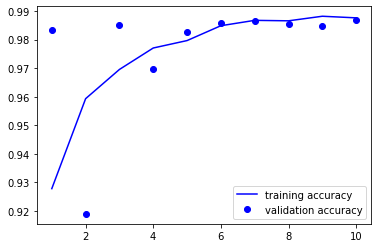

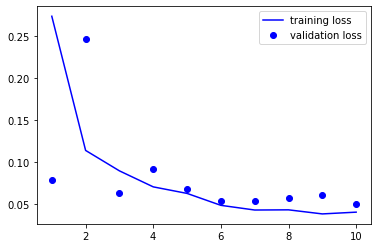

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'bo', label='validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'bo', label='validation loss')
plt.legend()
plt.show()

In [49]:
y_pred = model.predict(x[-2:])

In [50]:
y_pred.shape

(2, 224, 224, 1)

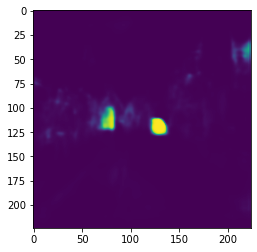

In [51]:
plt.imshow(y_pred[-1, :, :,0])

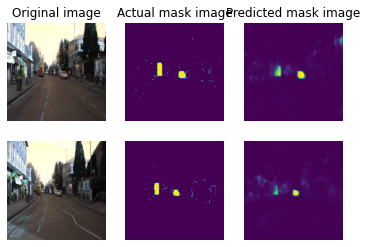

In [52]:
plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y2[-1,:,:,0])
plt.axis('off')
plt.title('Actual mask image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_pred[-1,:,:,0])
plt.axis('off')
plt.title('Predicted mask image')
plt.grid('off')

plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(235)
plt.imshow(y2[-2,:,:,0])
plt.axis('off')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_pred[-2,:,:,0])
plt.axis('off')
plt.grid('off')

In [47]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
plt.imshow(plt.imread('model.png'))